## Importa bibliotecas necessárias e paths

In [103]:
import pandas as pd
import numpy as np
import nltk
import re
import spacy
from unidecode import unidecode
from nltk import ngrams
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import PlaintextCorpusReader, stopwords
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
# nltk.download("all")
# no console: python -m spacy download pt_core_news_sm

In [9]:
fake = './Fake.br-Corpus/full_texts/fake/'
true = './Fake.br-Corpus/full_texts/true/'

## Carrega funções que serão usadas no pré-processamento

In [123]:
# Carrega corpus para dataframe
def read_texts(dir, class):
    '''
    dir - diretório onde estão os arquivos .txt
    class - qual a classe do diretório (usar 1 para fake e 0 para true)
    '''
    
    corpus = PlaintextCorpusReader(dir, r'[^.]*\.txt', encoding='utf-8') # r'[^.]*\.txt regex para considerar apenas arquivos .txt que não começam com um '.'
    files = corpus.fileids()
    classed_texts = [(fileid, corpus.raw(fileid), class) for fileid in files] # Cria uma lista de tuplas (Texto, class) para cada fileid
    
    return pd.DataFrame(classed_texts, columns=['fileid', 'text', 'class'])

# Pré-processamento

    ## Limpeza dos textos 
def clean_texts(text):
    text = text.lower() # Converte tudo para minúsculo
    text = re.sub(r'http\S+|www.\S+', '', text) # Remove URLs
    text = re.sub(r'\S+@\S+', '', text) # Remove e-mails
    text = text.replace('-', ' ') # Troca hífens por espaços
    text = re.sub(r'[^\w\s]', '', text) # Remove pontuações e caracteres especiais
    text = re.sub(r'\d+', '', text) # Remove números
    text = unidecode(text) # Usa a biblioteca unidecode para representar palavras com acentos em ASCII (exemplo: à -> a, ç -> c, etc.)
    text = re.sub(r'\s+', ' ', text).strip() # Remove excesso de espaços
    return text

    ## Tokenização dos textos
def tokenize_texts(text):
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    return [token for token in tokens if token not in stopwords_pt]

    ## Lemmatização dos textos
def lem_texts(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])
    
    ## Normalização dos textos
def truncate_tokens(tokens1, tokens2):
    min_len = min(len(tokens1), len(tokens2))
    return tokens1[:min_len], tokens2[:min_len]

## Carregando Corpus bruto

In [124]:
df_fake = read_texts(fake, 1)
df_true = read_texts(true, 0)

In [125]:
print(f"Tamanho do dataset fake: {len(df_fake)}\nTamanho do dataset true: {len(df_true)}")

Tamanho do dataset fake: 3600
Tamanho do dataset true: 3600


In [126]:
df_all = pd.concat([df_fake, df_true], ignore_index=True)

## Pré-processamento

- Limpando Corpus bruto

In [127]:
df_all['clean_txt'] = df_all['text'].apply(clean_texts)

In [128]:
df_all['clean_txt'].iloc[0][:400]

'katia abreu diz que vai colocar sua expulsao em uma moldura mas nao para de reclamar a senadora katia abreu sem partido to disse que sua expulsao do pmdb foi resultado de uma acao da cupula atual da legenda que segundo ela e oportunista amanha eu vou botar numa moldura dourada a minha expulsao porque das maos de onde veio e um atestado de boa conduta para o meu curriculo essas pessoas que me expul'

In [129]:
df_all['text'].iloc[0][:400]

'Kátia Abreu diz que vai colocar sua expulsão em uma moldura, mas não para de reclamar.\t\r\n\r\nA senadora Kátia Abreu (sem partido-TO) disse que sua expulsão do PMDB foi resultado de uma ação da cúpula atual da legenda que, segundo ela, é oportunista.\r\n\r\n“Amanhã eu vou botar numa moldura dourada a minha expulsão, porque das mãos de onde veio, é um atestado de boa conduta para o meu currículo. Essas pe'

- Lematização do corpus

In [130]:
nlp = spacy.load('pt_core_news_sm') # Carrega o modelo do spacy para português
df_all['lem_txt'] = df_all['clean_txt'].apply(lem_texts)

In [131]:
df_all['lem_txt'].iloc[0][:400]

'katia abrer dizer que ir colocar seu expulsao em um moldura mas nao para de reclamar o senadora katia abrer sem partido to dizer que seu expulsao de o pmdb ser resultado de um acao de o cupula atual de o legenda que segundo ela e oportunista amanho eu ir botar em um moldura dourar o meu expulsao porque de o mao de onde vir e um atestado de bom conduta para o meu curriculo esse pessoa que eu expuls'

- Tokenização do Corpus

In [132]:
# Carrega lista de stopwords
stopwords_pt = set(stopwords.words('portuguese'))

In [133]:
# Observação importante: Nossa função de tokenização usa uma verificação de stopwords para definir que tokens entram ou saem.
df_all['tokenized_text'] = df_all['lem_txt'].apply(tokenize_texts)

In [134]:
df_all['tokenized_text'].iloc[0][:9]

['katia',
 'abrer',
 'dizer',
 'ir',
 'colocar',
 'expulsao',
 'moldura',
 'nao',
 'reclamar']

In [135]:
df_all.to_csv('./df_all.csv', index=False, encoding='utf-8') 

- Normalização dos textos

In [136]:
# Calcular o número total de palavras em cada classe
total_fake_words = df_all[df_all['class'] == 1]['tokenized_text'].apply(len).sum()
total_true_words = df_all[df_all['class'] == 0]['tokenized_text'].apply(len).sum()
print(f'Total de palavras fake: {total_fake_words}\nTotal de palavras true: {total_true_words}')

Total de palavras fake: 398675
Total de palavras true: 2308799


In [139]:
normalized_texts = []
# Truncar textos para igualar os tamanhos dos pares fake e real
for fileid in df_all['fileid'].unique():
    fake_tokens = df_all[(df_all['fileid'] == fileid) & (df_all['class'] == 1)]['tokenized_text'].values[0]
    real_tokens = df_all[(df_all['fileid'] == fileid) & (df_all['class'] == 0)]['tokenized_text'].values[0]
    truncated_fake, truncated_real = truncate_tokens(fake_tokens, real_tokens)
    normalized_texts.append({
        'fileid': fileid, 
        'texto_normalizado': ' '.join(truncated_fake), 
        'tokenized_text': truncated_fake,
        'class': 1
    })
    normalized_texts.append({
        'fileid': fileid, 
        'texto_normalizado': ' '.join(truncated_real), 
        'tokenized_text': truncated_real,
        'class': 0
    })

In [142]:
normalized_df = pd.DataFrame(normalized_texts)
# Calcular o número total de palavras em cada classe
total_fake_words = normalized_df[normalized_df['class'] == 1]['tokenized_text'].apply(len).sum()
total_true_words = normalized_df[normalized_df['class'] == 0]['tokenized_text'].apply(len).sum()
print(f'Total de palavras fake: {total_fake_words}\nTotal de palavras true: {total_true_words}')

Total de palavras fake: 392261
Total de palavras true: 392261


In [143]:
normalized_df.to_csv('./df_all_normalizado.csv', index=False, encoding='utf-8') 

# Treinamento

### Separação do corpus em treino/teste

In [4]:
df = pd.read_csv('./df_all_normalizado.csv', encoding='utf-8')
df.head()

,fileid,texto_normalizado,tokenized_text,class
0,1.txt,katia abrer dizer ir colocar expulsao moldura ...,"['katia', 'abrer', 'dizer', 'ir', 'colocar', '...",1
1,1.txt,poder decidir expulsar deputado federal Carlos...,"['poder', 'decidir', 'expulsar', 'deputado', '...",0
2,10.txt,dr Ray peito bolsonaro chamar conservador Fake...,"['dr', 'Ray', 'peito', 'bolsonaro', 'chamar', ...",1
3,10.txt,bolsonaro liberal completo dizer presidente ps...,"['bolsonaro', 'liberal', 'completo', 'dizer', ...",0
4,100.txt,reinaldo azevedo desmascarar policia federal f...,"['reinaldo', 'azevedo', 'desmascarar', 'polici...",1


In [7]:
x = df["texto_normalizado"].to_numpy()
y = df["class"].to_numpy()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1234)

In [8]:
print(len(x_train), len(x_test), len(y_train), len(y_test))

5400 1800 5400 1800


### Instancia objeto pipeline para treinar o classificador

RU 4027529

In [53]:
pipeline_svm = make_pipeline(TfidfVectorizer(), SVC())

In [59]:
# Ajuste de hiperparâmetros usando GridSearchCV
parameters_svm = {
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2)],  # Unigramas e Bigramas
    'tfidfvectorizer__max_df': [0.75, 1.0],  # Limitar o número de max_df
    'tfidfvectorizer__min_df': [1],  # Limitar o número de min_df a um valor
    'svc__C': [1, 10],  # Parâmetro de regularização com duas opções
    'svc__kernel': ['linear']  # Apenas kernel linear
}

### Treina o modelo

In [60]:
# Treinar o modelo
grid_search = GridSearchCV(pipeline_svm, parameters_svm, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                                       ('svc', SVC())]),
             param_grid={'svc__C': [1, 10], 'svc__kernel': ['linear'],
                         'tfidfvectorizer__max_df': [0.75, 1.0],
                         'tfidfvectorizer__min_df': [1],
                         'tfidfvectorizer__ngram_range': [(1, 1), (1, 2)]},
             scoring='accuracy')

In [61]:
# Melhor conjunto de hiperparâmetros
print("Melhores hiperparâmetros:", grid_search.best_params_)

Melhores hiperparâmetros: {'svc__C': 10, 'svc__kernel': 'linear', 'tfidfvectorizer__max_df': 0.75, 'tfidfvectorizer__min_df': 1, 'tfidfvectorizer__ngram_range': (1, 2)}


In [62]:
best_model = grid_search.best_estimator_ # Pega a melhor combinação de hiper-parâmetros 

In [63]:
# Fazer previsões no conjunto de teste
y_pred = best_model.predict(x_test)

In [65]:
# Avaliar o modelo
print("Acurácia:", accuracy_score(y_test, y_pred))

Acurácia: 0.9044444444444445


# Questões


III.	Responda à pergunta: Quantas palavras, bigramas e trigramas foram usados dos textos rotulados como REAL para a criação de seu modelo e qual a acurácia?
Resposta: (COLOCAR RESPOSTA AQUI)


In [88]:
train_data = pd.DataFrame({
    "texto_normalizado": X_train,
    "class": y_train
})

In [89]:
real_texts = train_data[train_data["class"] == 0]
real_texts.head()

,texto_normalizado,class
0,alto tribunal justica stj analisar partir h te...,0
1,quinta feira abril semana comecar ainda presid...,0
3,pronto desde projeto contorno ferroviario divi...,0
6,Jugmann pedir Supremo retomar discussao estabe...,0
7,autoflagelacao farra chocolate ritual marcar p...,0


In [90]:
tfidf_vectorizer = grid_search.best_estimator_.named_steps['tfidfvectorizer'] # Pega o TF-IDF do modelo treinado

In [92]:
x_real_tfidf = tfidf_vectorizer.transform(real_texts['texto_normalizado']) # Aplica ele nos textos REAIS
x_real_tfidf.shape

(2704, 391383)

In [101]:
feature_names_0 = tfidf_vectorizer.get_feature_names_out() # Extrai as features
# Contar os unigramas, bigramas e trigramas
num_unigrams = sum(1 for ngram in feature_names_0 if len(ngram.split()) == 1)
num_bigrams = sum(1 for ngram in feature_names_0 if len(ngram.split()) == 2)
num_trigrams = sum(1 for ngram in feature_names_0 if len(ngram.split()) == 3)
# Resultados
print(f"Número total de palavras (unigramas): {num_unigrams}")
print(f"Número total de bigramas: {num_bigrams}")
print(f"Número total de trigramas: {num_trigrams}")
print("Acurácia:", accuracy_score(y_test, y_pred))

Número total de palavras (unigramas): 29994
Número total de bigramas: 361389
Número total de trigramas: 0
Acurácia: 0.9044444444444445


III.	Responda à pergunta: Quantas palavras, bigramas e trigramas foram usados dos textos rotulados como FAKE para a criação de seu modelo, quais foram as técnicas usadas em seu pré-processamento e qual tipo de modelo foi escolhido para este classificador?

In [94]:
# Mesmo passo-a-passo para o conjunto de fake news
fake_texts = train_data[train_data["class"] == 1]
fake_texts.head()

,texto_normalizado,class
2,video virar piado Internet pateta comemorar an...,1
4,fim linha ministro stj negar habea corpus lula...,1
5,gilmar mende receber secretamente temer dois m...,1
8,vergonha concessionario cortar energia maracan...,1
12,ciro algum autoridade decretar prisao lula ire...,1


In [100]:
x_fake_tfidf = tfidf_vectorizer.transform(fake_texts['texto_normalizado'])
feature_names_1 = tfidf_vectorizer.get_feature_names_out() # Extrai as features
# Contar os unigramas, bigramas e trigramas
num_unigrams = sum(1 for ngram in feature_names_1 if len(ngram.split()) == 1)
num_bigrams = sum(1 for ngram in feature_names_1 if len(ngram.split()) == 2)
num_trigrams = sum(1 for ngram in feature_names_1 if len(ngram.split()) == 3)
# Resultados
print(f"Número total de palavras (unigramas): {num_unigrams}")
print(f"Número total de bigramas: {num_bigrams}")
print(f"Número total de trigramas: {num_trigrams}")


Número total de palavras (unigramas): 29994
Número total de bigramas: 361389
Número total de trigramas: 0


# Wordclouds

- Real news

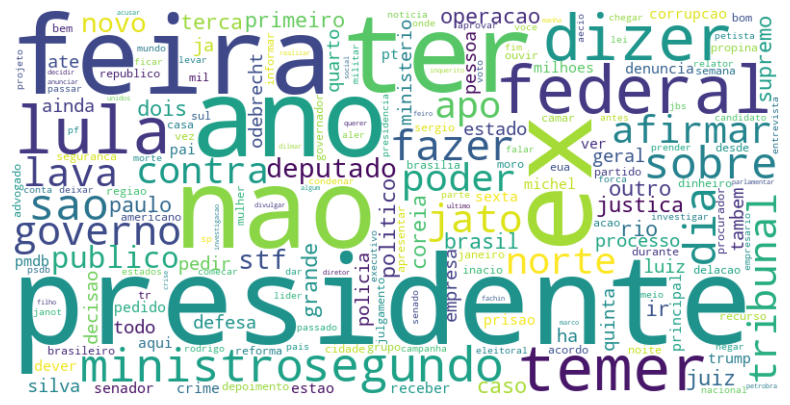

In [105]:
# Contar os unigramas
unigram_indices = [i for i, ngram in enumerate(feature_names_0) if len(ngram.split()) == 1]

# Somar as frequências TF-IDF dos unigramas
unigram_freq = np.sum(x_real_tfidf[:, unigram_indices], axis=0).A1
unigrams = feature_names_0[unigram_indices]
unigram_freq_dict = dict(zip(unigrams, unigram_freq))

# Gerar a nuvem de palavras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(unigram_freq_dict)

# Plotar a nuvem de palavras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

- Fake news

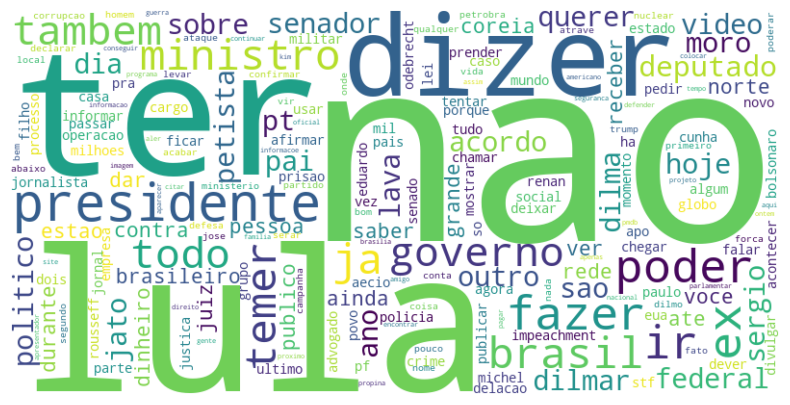

In [104]:
# Contar os unigramas
unigram_indices = [i for i, ngram in enumerate(feature_names_1) if len(ngram.split()) == 1]

# Somar as frequências TF-IDF dos unigramas
unigram_freq = np.sum(x_fake_tfidf[:, unigram_indices], axis=0).A1
unigrams = feature_names_1[unigram_indices]
unigram_freq_dict = dict(zip(unigrams, unigram_freq))

# Gerar a nuvem de palavras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(unigram_freq_dict)

# Plotar a nuvem de palavras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()